In [14]:
import torch
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [6]:
# Make sure torch version is compatible with Cuda 10.1
torch.__version__

'1.7.1+cu101'

In [10]:
# Make fastai version is 1
pip show fastai

Name: fastai
Version: 1.0.61
Summary: fastai makes deep learning with PyTorch faster, more accurate, and easier
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: requests, numpy, matplotlib, nvidia-ml-py3, pyyaml, scipy, bottleneck, pandas, torch, torchvision, numexpr, spacy, Pillow, fastprogress, packaging, beautifulsoup4
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [12]:
torch.cuda.is_available()

True

In [13]:
torch.cuda.set_device(0)

### Data Prep

In [17]:
path = '../data/imgs/all'
df = pd.read_csv(path+'/image_label_dir.csv' ,header='infer')
df.head()

,image_id,label
0,2019-01-30.png,8
1,2019-01-31.png,3
2,2019-02-01.png,8
3,2019-02-04.png,5
4,2019-02-05.png,9


In [18]:
data = ImageDataBunch.from_df(path, df, valid_pct=0.2, size=224)

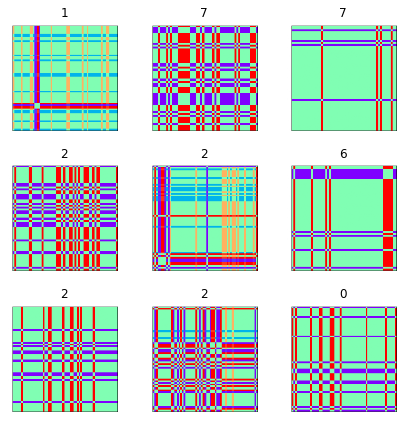

In [19]:
data.show_batch(rows=3, figsize=(6,6))

### Base CNN (ResNet34 + Custom Head)

In [32]:
# Create custom_head
layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(1024,10)]
head = nn.Sequential(*layers)

In [33]:
learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True,
                      custom_head=head,
                      metrics=[error_rate, accuracy]).to_fp16()
learner.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)

### Finding the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.36E-04
Min loss divided by 10: 1.90E-03


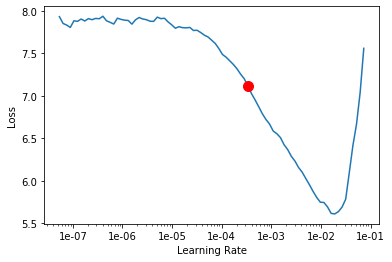

In [36]:
learner.lr_find(start_lr=1e-08,end_lr=0.2, num_it=100)
learner.recorder.plot(suggestion=True)

In [37]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.00033623165424224245


### Training the leraner

In [38]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,7.878437,5.697142,0.868687,0.131313,00:07
1,7.156829,5.208963,0.909091,0.090909,00:07
2,6.181125,4.630376,0.939394,0.060606,00:07
3,5.416727,4.332784,0.909091,0.090909,00:07
4,4.873260,3.904386,0.848485,0.151515,00:07
5,4.437532,3.878982,0.909091,0.090909,00:07
6,4.075118,3.819341,0.909091,0.090909,00:07
7,3.788651,3.743885,0.909091,0.090909,00:07
8,3.567121,3.726040,0.898990,0.101010,00:07
9,3.373476,3.718999,0.898990,0.101010,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.41E-05
Min loss divided by 10: 2.14E-04


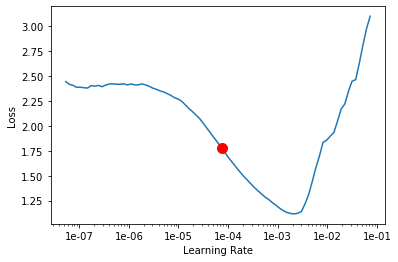

In [39]:
learner.unfreeze()
learner.lr_find(start_lr=1e-08,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [40]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

7.405355256012057e-05


### Differential learning

In [41]:
# Differential learning 
learner.fit_one_cycle(7, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.429375,3.704928,0.888889,0.111111,00:07
1,2.147904,3.652609,0.919192,0.080808,00:07
2,1.727651,3.595088,0.898990,0.101010,00:08
3,1.362491,3.587476,0.898990,0.101010,00:08
4,1.076279,3.571918,0.878788,0.121212,00:07
5,0.875035,3.561521,0.868687,0.131313,00:07
6,0.725609,3.580045,0.878788,0.121212,00:08


### Results

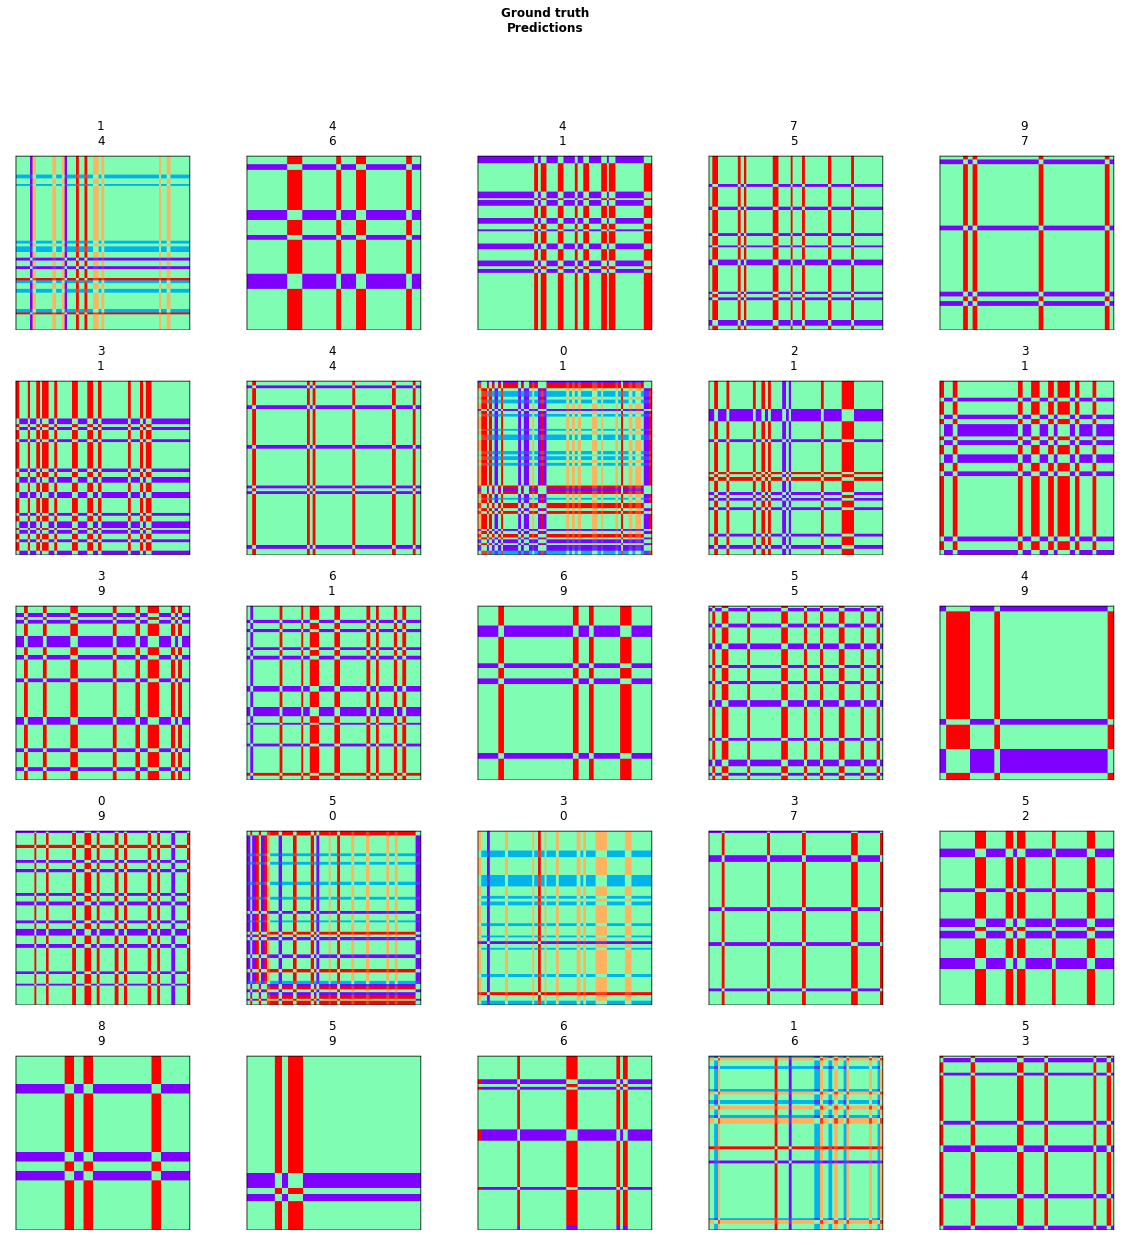

In [42]:
learner.show_results()

### Save